## Adversarial Attacks and FGSM

### Adversarial Attacks
Adversarial attacks involve creating small, intentionally crafted perturbations to input data that can deceive machine learning models into making incorrect predictions. Despite the perturbations being nearly imperceptible to humans, they can cause a model to misclassify inputs with high confidence.

### Fast Gradient Sign Method (FGSM)
The Fast Gradient Sign Method (FGSM) is a straightforward and efficient technique for generating adversarial examples. It perturbs the input data by adding a small amount of noise in the direction of the gradient of the loss with respect to the input. The perturbation is scaled by a factor known as epsilon (ε), which controls the magnitude of the attack. Mathematically, this is expressed as:
$$
x_{\text{adv}} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta, x, y))
$$
Where:
- $ x_{\text{adv}} $ is the adversarial example.
- $ x $ is the original input.
- $\epsilon$ is the perturbation magnitude.
- $ \nabla_x J(\theta, x, y) $ is the gradient of the loss $ J $ with respect to the input $ x $.
- $ \theta $ represents the model parameters.
- $ y $ is the true label of the input.

### Implementation in This Cell
In this cell, we implemented a simple Convolutional Neural Network (CNN) and trained it on the MNIST dataset. We then applied the FGSM to generate adversarial examples and tested the model's robustness against these attacks. The effects of varying epsilon values on the model's predictions were also analyzed and visualized.


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5153460.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 149470.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1424973.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11517852.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/5], Step [900/938], Loss: 0.0951
Epoch [2/5], Step [900/938], Loss: 0.0060
Epoch [3/5], Step [900/938], Loss: 0.0014
Epoch [4/5], Step [900/938], Loss: 0.0287
Epoch [5/5], Step [900/938], Loss: 0.0126
Epsilon: 0.05, Success rate: 5


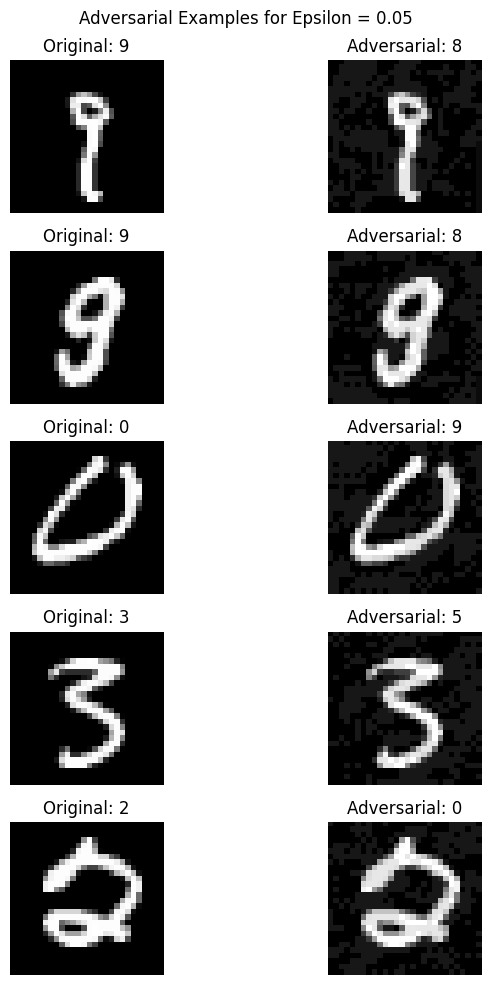

Epsilon: 0.1, Success rate: 5


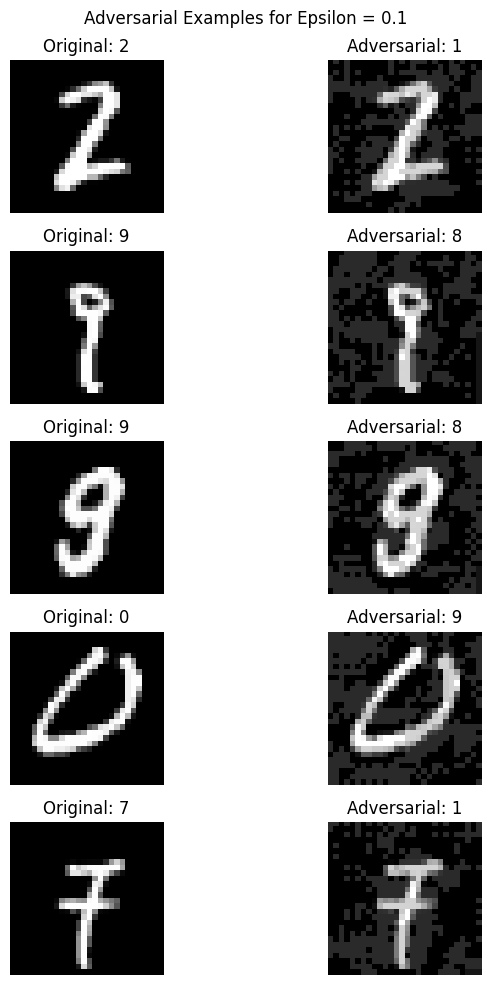

Epsilon: 0.15, Success rate: 5


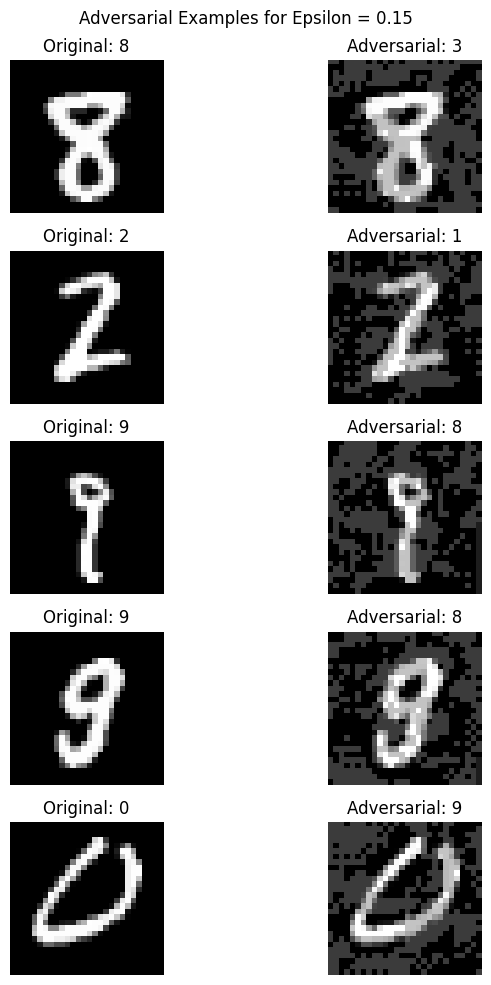

Epsilon: 0.2, Success rate: 5


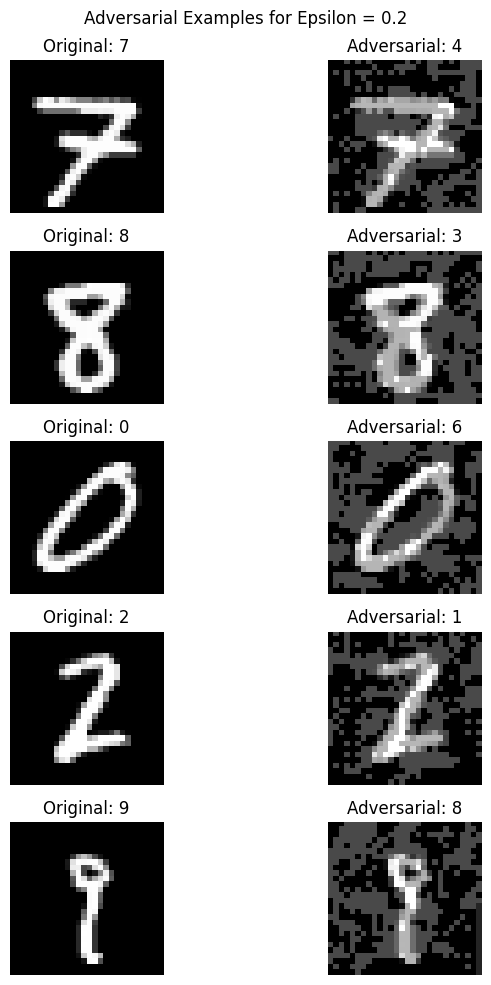

Epsilon: 0.25, Success rate: 5


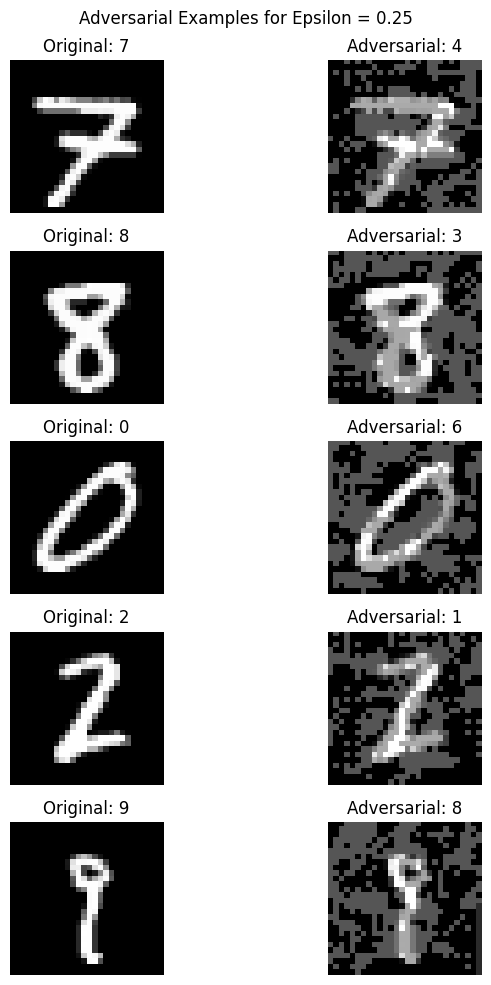

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 7*7*64)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 4. Instantiate the model, define the loss and the optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Train the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i + 1) % 900 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Train the model for 5 epochs
train(model, train_loader, criterion, optimizer, epochs=5)

# 6. FGSM attack function
def fgsm_attack(model, loss_fn, x, y, epsilon):
    # Clone the input to make it a leaf variable
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)

    output = model(x_adv)
    loss = loss_fn(output, y)

    # Zero all existing gradients
    model.zero_grad()

    # Backpropagate to calculate the gradient of the loss w.r.t. the input image
    loss.backward()

    # Collect the sign of the gradients
    gradient = x_adv.grad.data
    sign_gradient = gradient.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    x_adv = x_adv + epsilon * sign_gradient

    # Return the perturbed image
    return x_adv


# 7. Fine-tune epsilon and display adversarial examples
def show_adversarial_examples(model, test_loader, epsilon_values):
    model.eval()

    for epsilon in epsilon_values:
        success_count = 0
        adv_examples = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images.requires_grad = True

            outputs = model(images)
            _, preds = outputs.max(1)

            correct_indices = preds.eq(labels).nonzero(as_tuple=True)[0]
            if len(correct_indices) == 0:
                continue

            idx = correct_indices[0].item()
            image = images[idx:idx+1]
            label = labels[idx:idx+1]

            adv_image = fgsm_attack(model, criterion, image, label, epsilon)

            output = model(adv_image)
            _, adv_pred = output.max(1)

            if adv_pred.item() != label.item():
                success_count += 1
                adv_examples.append((image, adv_image, label, adv_pred))

            if success_count >= 5:
                break

        # Display results for this epsilon
        print(f"Epsilon: {epsilon}, Success rate: {success_count}")
        fig, axs = plt.subplots(len(adv_examples), 2, figsize=(8, 10))
        for i, (orig, adv, label, pred) in enumerate(adv_examples):
            axs[i, 0].imshow(orig.squeeze().detach().cpu().numpy(), cmap="gray")
            axs[i, 0].set_title(f"Original: {label.item()}")
            axs[i, 0].axis('off')
            axs[i, 1].imshow(adv.squeeze().detach().cpu().numpy(), cmap="gray")
            axs[i, 1].set_title(f"Adversarial: {pred.item()}")
            axs[i, 1].axis('off')

        plt.suptitle(f"Adversarial Examples for Epsilon = {epsilon}")
        plt.tight_layout()
        plt.show()

# 8. Fine-tune epsilon values
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
show_adversarial_examples(model, test_loader, epsilon_values)


## Basic Iterative Method (BIM)

### Basic Iterative Method (BIM)
The Basic Iterative Method (BIM) is an extension of the Fast Gradient Sign Method (FGSM). It generates adversarial examples by applying FGSM multiple times with small steps, refining the perturbations iteratively. BIM is also known as the Iterative FGSM (I-FGSM). The key idea is to iteratively apply the FGSM, allowing the model to gradually move the input towards an adversarial example within the allowable perturbation range.

Mathematically, BIM is expressed as:

$$
x_{\text{adv}}^{(0)} = x
$$

$$
x_{\text{adv}}^{(n+1)} = \text{clip}_{x,\epsilon} \left\{ x_{\text{adv}}^{(n)} + \alpha \cdot \text{sign}(\nabla_x J(\theta, x_{\text{adv}}^{(n)}, y)) \right\}
$$

Where:
- $ x_{\text{adv}}^{(n)} $ is the adversarial example at iteration $ n $.
- $ x $ is the original input.
- $ \epsilon $ is the maximum perturbation allowed.
- $ \alpha $ is the step size (perturbation increment per iteration).
- $ \text{clip}_{x,\epsilon} $ ensures that the perturbation stays within the bounds $ [-\epsilon, \epsilon] $ and the adversarial example remains within valid input space.

### Implementation in This Cell
In this cell, we implemented the BIM attack on a pre-trained CNN model. We first define the `bim_attack` function, which iteratively applies small perturbations to the input image. Then, we evaluate and visualize the effectiveness of BIM by generating adversarial examples using various epsilon values. Finally, we compare the results of BIM with FGSM by observing the model’s performance against these adversarial examples.



-- BIM Results --
BIM Attack: Epsilon = 0.05, Alpha = 0.01, Iterations = 10, Success rate = 5


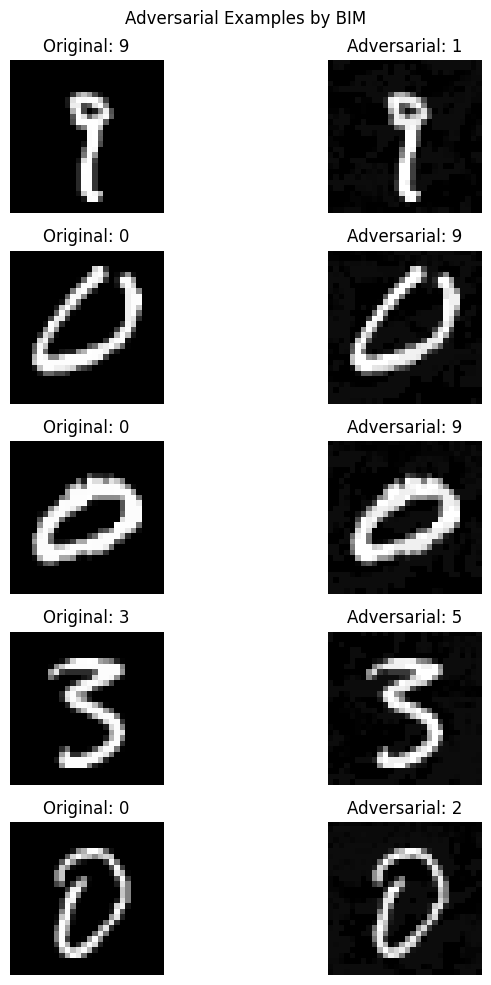

BIM Attack: Epsilon = 0.1, Alpha = 0.01, Iterations = 10, Success rate = 5


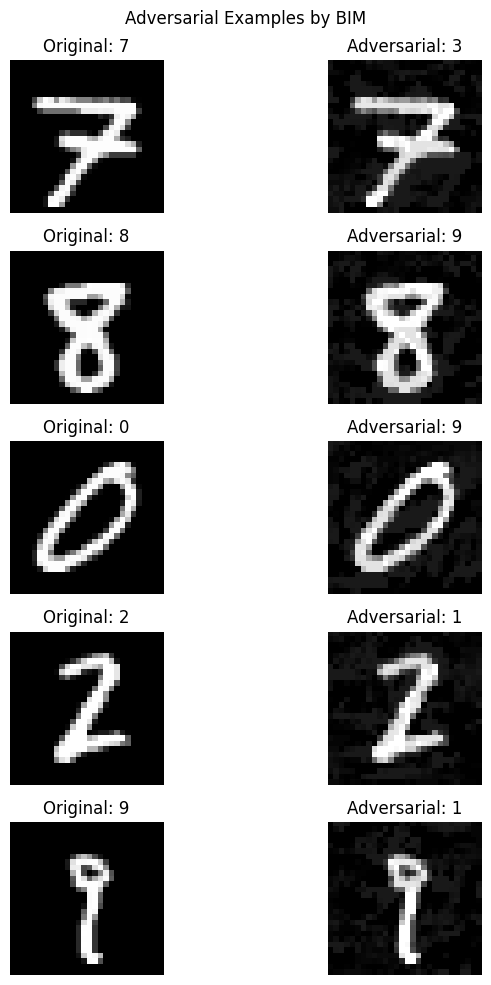

BIM Attack: Epsilon = 0.15, Alpha = 0.01, Iterations = 10, Success rate = 5


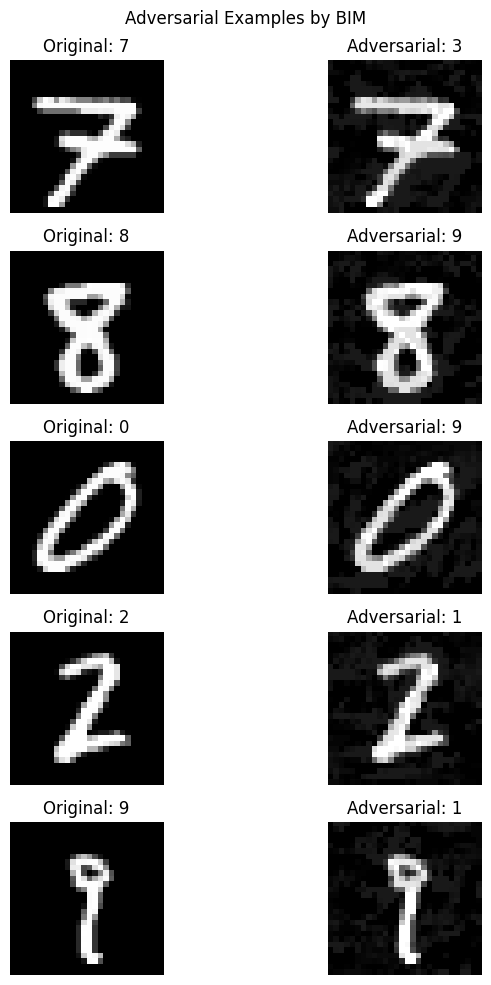

In [11]:
# 1. Basic Iterative Method (BIM) attack function
def bim_attack(model, loss_fn, x, y, epsilon, alpha, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)

    for _ in range(num_iter):
        output = model(x_adv)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        gradient = x_adv.grad.data
        x_adv = x_adv + alpha * gradient.sign()
        perturbation = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + perturbation, min=0, max=1).detach_()
        x_adv.requires_grad_(True)

    return x_adv


# 2. Show adversarial examples generated by BIM
def show_bim_adversarial_examples(model, test_loader, epsilon, alpha, num_iter):
    model.eval()
    success_count = 0
    adv_examples = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        outputs = model(images)
        _, preds = outputs.max(1)

        correct_indices = preds.eq(labels).nonzero(as_tuple=True)[0]
        if len(correct_indices) == 0:
            continue

        idx = correct_indices[0].item()
        image = images[idx:idx+1]
        label = labels[idx:idx+1]

        # Apply BIM attack
        adv_image = bim_attack(model, criterion, image, label, epsilon, alpha, num_iter)

        # Re-classify the perturbed image
        output = model(adv_image)
        _, adv_pred = output.max(1)

        if adv_pred.item() != label.item():
            success_count += 1
            adv_examples.append((image, adv_image, label, adv_pred))

        if success_count >= 5:
            break

    print(f"BIM Attack: Epsilon = {epsilon}, Alpha = {alpha}, Iterations = {num_iter}, Success rate = {success_count}")
    fig, axs = plt.subplots(len(adv_examples), 2, figsize=(8, 10))
    for i, (orig, adv, label, pred) in enumerate(adv_examples):
        axs[i, 0].imshow(orig.squeeze().detach().cpu().numpy(), cmap="gray")
        axs[i, 0].set_title(f"Original: {label.item()}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(adv.squeeze().detach().cpu().numpy(), cmap="gray")
        axs[i, 1].set_title(f"Adversarial: {pred.item()}")
        axs[i, 1].axis('off')

    plt.suptitle(f"Adversarial Examples by BIM")
    plt.tight_layout()
    plt.show()

# 3. BIM examples
def BIM_examples(model, test_loader, epsilon_values, alpha, num_iter):
    # BIM examples
    print("\n-- BIM Results --")
    for epsilon in epsilon_values:
        show_bim_adversarial_examples(model, test_loader, epsilon, alpha, num_iter)

# Parameters for BIM
alpha = 0.01  # Step size
num_iter = 10  # Number of iterations
epsilon_values = [0.05, 0.1, 0.15]  # Epsilon values for comparison

BIM_examples(model, test_loader, epsilon_values, alpha, num_iter)


## Projected Gradient Descent (PGD)

### Projected Gradient Descent (PGD)
Projected Gradient Descent (PGD) is a more powerful and iterative adversarial attack method based on the Basic Iterative Method (BIM). The key difference is that PGD adds random initialization to the input before starting the iterative process. After each update, the adversarial example is "projected" back to a valid space by ensuring that it remains within the allowed perturbation bounds.

Mathematically, PGD can be expressed as:

1. **Initialization**:
   $$
   x_{\text{adv}}^{(0)} = x + \delta, \quad \delta \sim \mathcal{U}(-\epsilon, \epsilon)
   $$

2. **Iterative Update**:
   $$
   x_{\text{adv}}^{(n+1)} = \text{clip}_{x,\epsilon} \left\{ x_{\text{adv}}^{(n)} + \alpha \cdot \text{sign}(\nabla_x J(\theta, x_{\text{adv}}^{(n)}, y)) \right\}
   $$

Where:
- $ x_{\text{adv}}^{(n)} $ is the adversarial example at iteration $ n $.
- $ x $ is the original input.
- $ \delta $ is the random initialization within the range $ [-\epsilon, \epsilon] $.
- $ \epsilon $ is the maximum allowed perturbation.
- $ \alpha $ is the step size for each iteration.
- $ \text{clip}_{x,\epsilon} $ projects the perturbed image back within the valid input range.

### Implementation in This Cell
In this cell, we implemented the PGD attack on a pre-trained CNN model. The `pgd_attack` function performs the attack by starting with a random perturbation of the input image, followed by iterative updates, similar to BIM. We then evaluate the model's vulnerability to these adversarial examples by generating and visualizing examples using various epsilon values.



-- PGD Results --
PGD Attack: Epsilon = 0.05, Alpha = 0.01, Iterations = 10, Success rate = 5


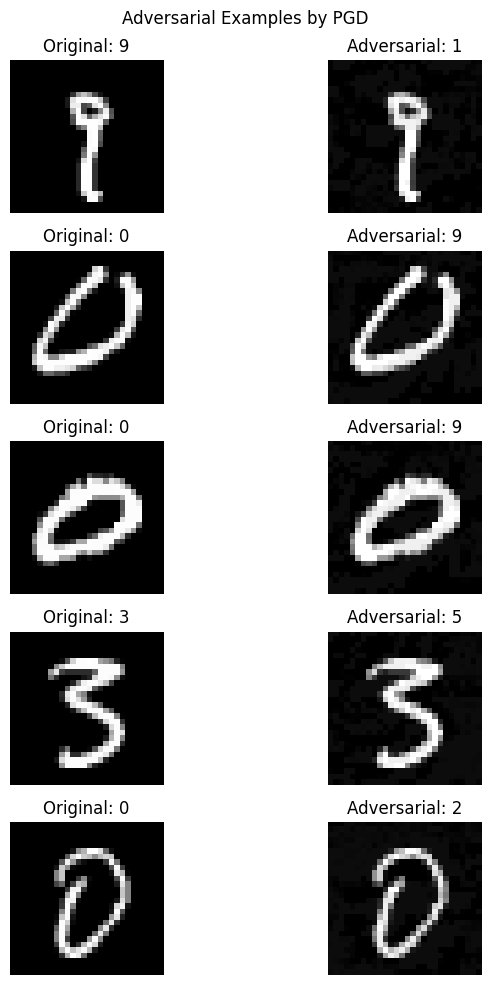

PGD Attack: Epsilon = 0.1, Alpha = 0.01, Iterations = 10, Success rate = 5


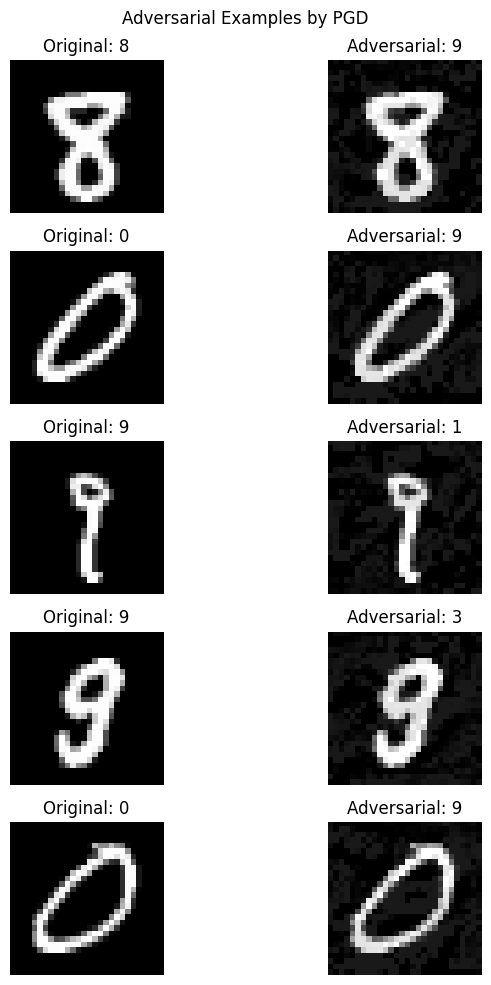

PGD Attack: Epsilon = 0.15, Alpha = 0.01, Iterations = 10, Success rate = 5


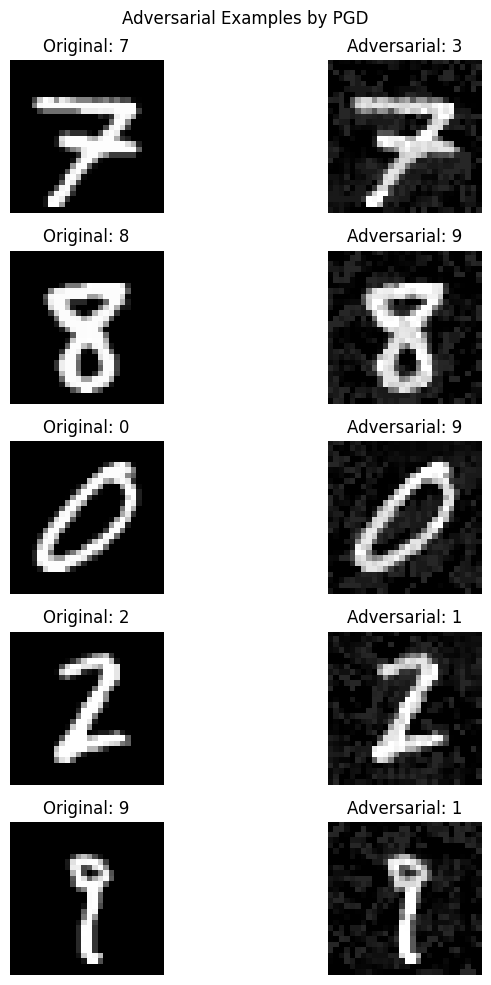

In [10]:
# 1. Projected Gradient Descent (PGD) attack function
def pgd_attack(model, loss_fn, x, y, epsilon, alpha, num_iter):
    x_adv = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
    x_adv = torch.clamp(x_adv, min=0, max=1).detach().requires_grad_(True).to(x.device)

    for _ in range(num_iter):
        output = model(x_adv)
        loss = loss_fn(output, y)
        model.zero_grad()
        loss.backward()
        gradient = x_adv.grad.data
        x_adv = x_adv + alpha * gradient.sign()
        perturbation = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + perturbation, min=0, max=1).detach_()
        x_adv.requires_grad_(True)

    return x_adv


# 2. Show adversarial examples generated by PGD
def show_pgd_adversarial_examples(model, test_loader, epsilon, alpha, num_iter):
    model.eval()
    success_count = 0
    adv_examples = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        outputs = model(images)
        _, preds = outputs.max(1)

        correct_indices = preds.eq(labels).nonzero(as_tuple=True)[0]
        if len(correct_indices) == 0:
            continue

        idx = correct_indices[0].item()
        image = images[idx:idx+1]
        label = labels[idx:idx+1]

        # Apply PGD attack
        adv_image = pgd_attack(model, criterion, image, label, epsilon, alpha, num_iter)

        # Re-classify the perturbed image
        output = model(adv_image)
        _, adv_pred = output.max(1)

        if adv_pred.item() != label.item():
            success_count += 1
            adv_examples.append((image, adv_image, label, adv_pred))

        if success_count >= 5:
            break

    print(f"PGD Attack: Epsilon = {epsilon}, Alpha = {alpha}, Iterations = {num_iter}, Success rate = {success_count}")
    fig, axs = plt.subplots(len(adv_examples), 2, figsize=(8, 10))
    for i, (orig, adv, label, pred) in enumerate(adv_examples):
        axs[i, 0].imshow(orig.squeeze().detach().cpu().numpy(), cmap="gray")
        axs[i, 0].set_title(f"Original: {label.item()}")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(adv.squeeze().detach().cpu().numpy(), cmap="gray")
        axs[i, 1].set_title(f"Adversarial: {pred.item()}")
        axs[i, 1].axis('off')

    plt.suptitle(f"Adversarial Examples by PGD")
    plt.tight_layout()
    plt.show()

# 3. PGD examples
def PGD_examples(model, test_loader, epsilon_values, alpha, num_iter):
    # PGD examples
    print("\n-- PGD Results --")
    for epsilon in epsilon_values:
        show_pgd_adversarial_examples(model, test_loader, epsilon, alpha, num_iter)

# Parameters for PGD
alpha = 0.01  # Step size
num_iter = 10  # Number of iterations
epsilon_values = [0.05, 0.1, 0.15]  # Epsilon values for comparison

PGD_examples(model, test_loader, epsilon_values, alpha, num_iter)


## Comparing FGSM, BIM, and PGD Attacks

### Visual Comparison of FGSM, BIM, and PGD
In this cell, we compare the effectiveness of three different adversarial attack methods—FGSM, BIM, and PGD—by visually examining the adversarial examples they generate. The function `compare_fgsm_bim_pgd` runs each attack on the same model and dataset across different epsilon values, and then displays the results for side-by-side comparison.

This comparison allows us to observe how the different methods, which vary in complexity and iteration, affect the model's predictions and generate adversarial examples. By printing and visualizing the results, we can analyze the relative effectiveness of each attack method.



-- FGSM Results --
Epsilon: 0.05, Success rate: 5


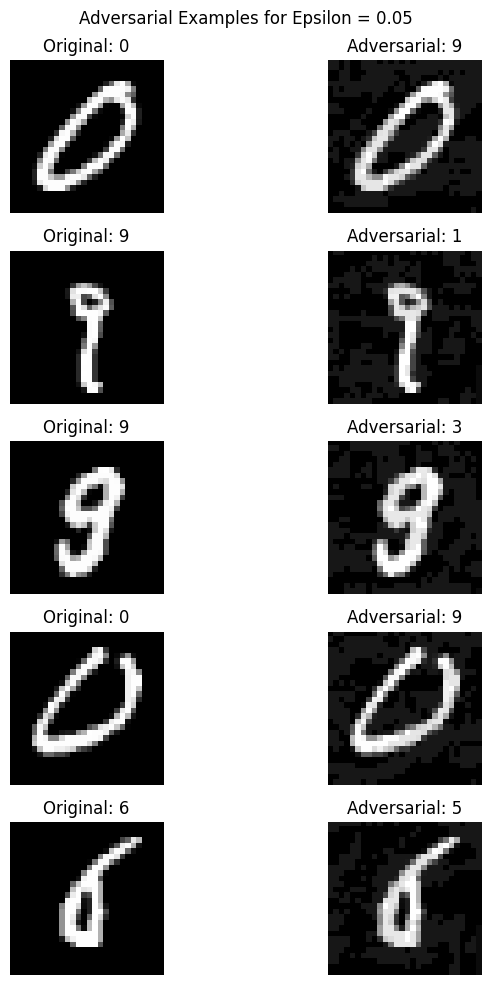

Epsilon: 0.1, Success rate: 5


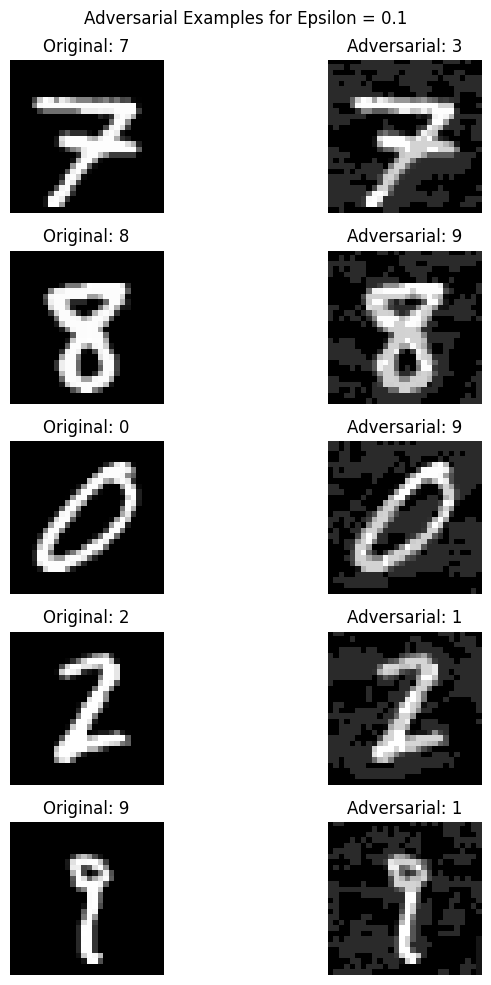

Epsilon: 0.15, Success rate: 5


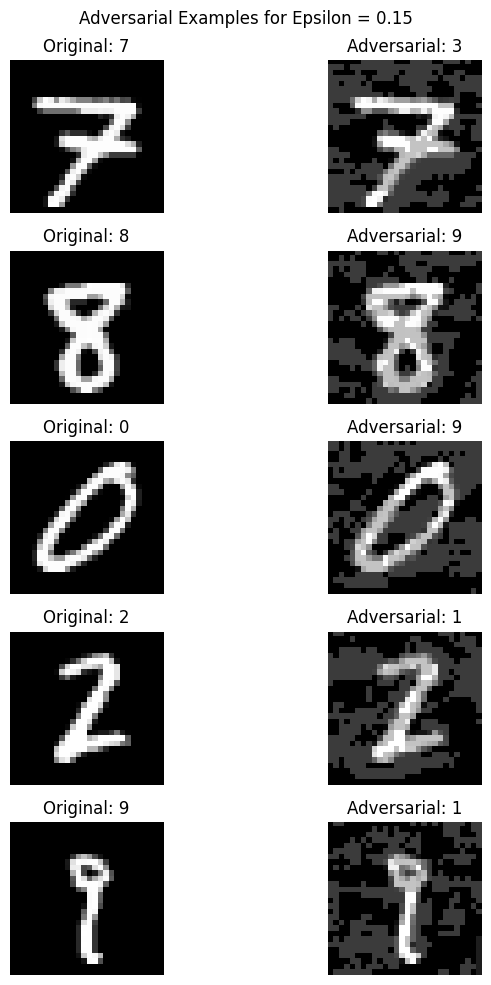

Epsilon: 0.2, Success rate: 5


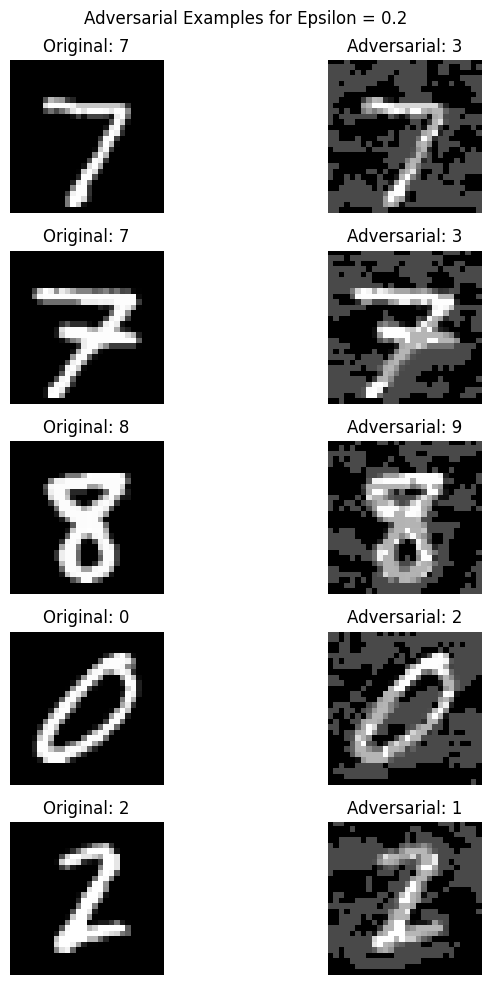

Epsilon: 0.25, Success rate: 5


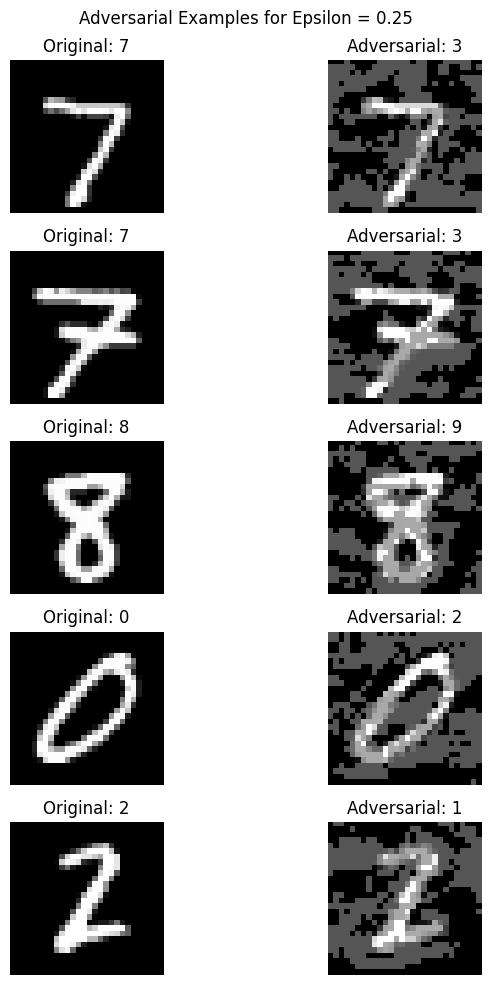


-- BIM Results --
BIM Attack: Epsilon = 0.05, Alpha = 0.01, Iterations = 10, Success rate = 5


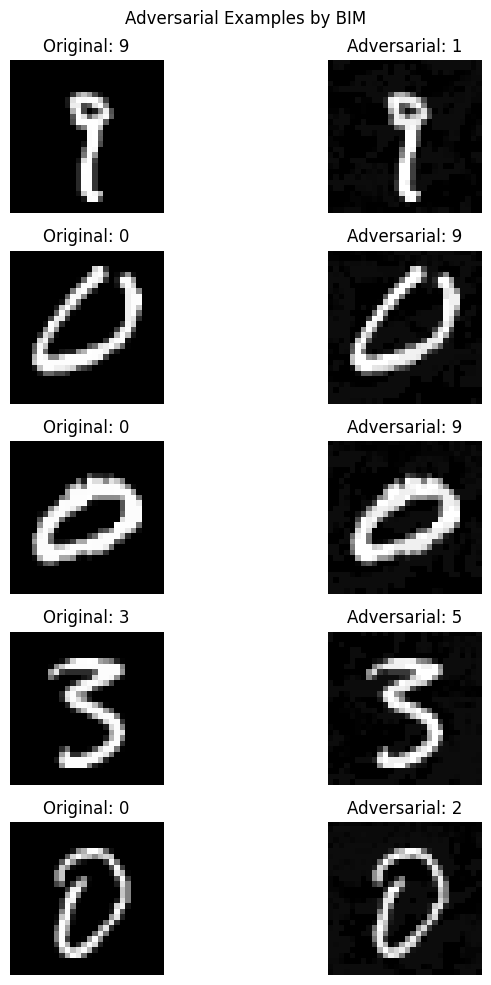

BIM Attack: Epsilon = 0.1, Alpha = 0.01, Iterations = 10, Success rate = 5


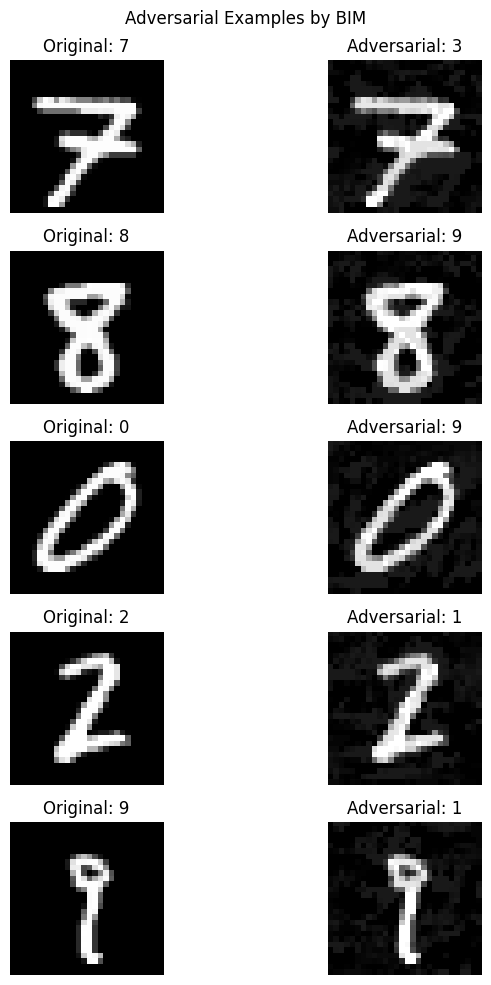

BIM Attack: Epsilon = 0.15, Alpha = 0.01, Iterations = 10, Success rate = 5


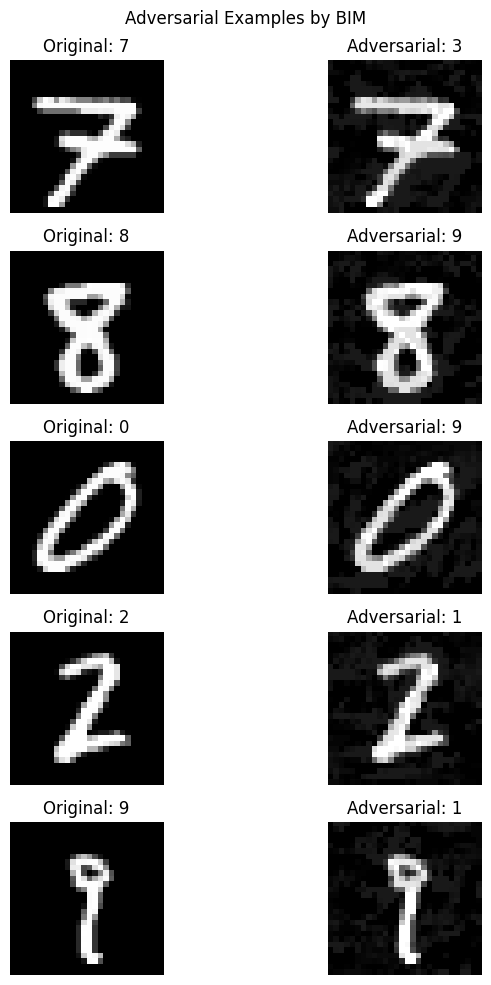

BIM Attack: Epsilon = 0.2, Alpha = 0.01, Iterations = 10, Success rate = 5


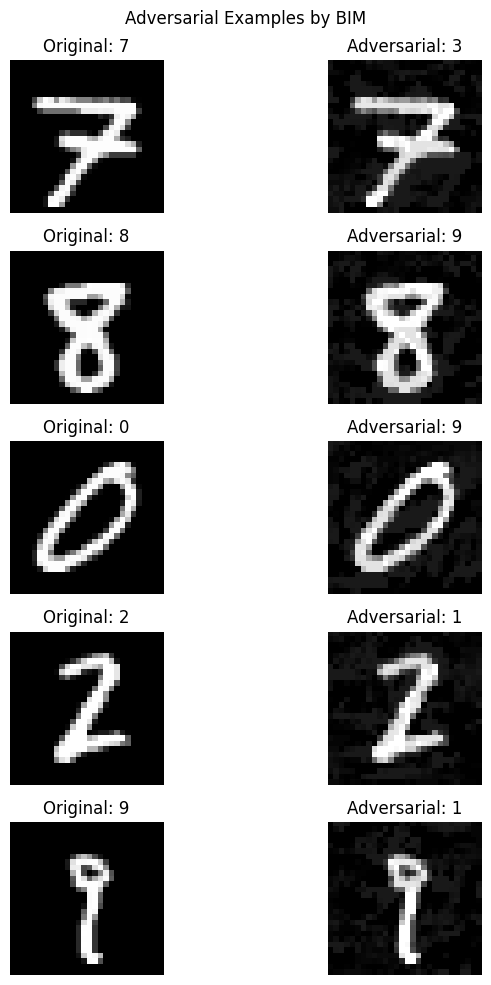

BIM Attack: Epsilon = 0.25, Alpha = 0.01, Iterations = 10, Success rate = 5


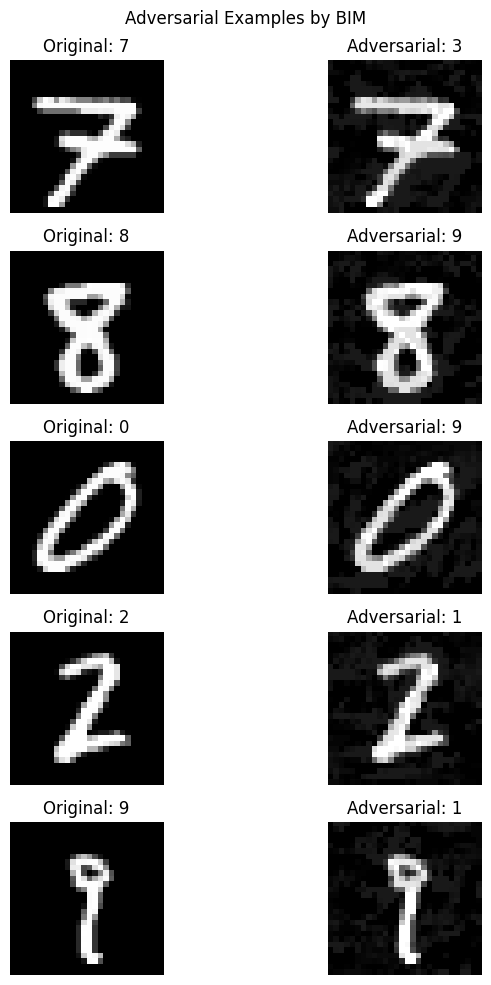


-- PGD Results --
PGD Attack: Epsilon = 0.05, Alpha = 0.01, Iterations = 10, Success rate = 5


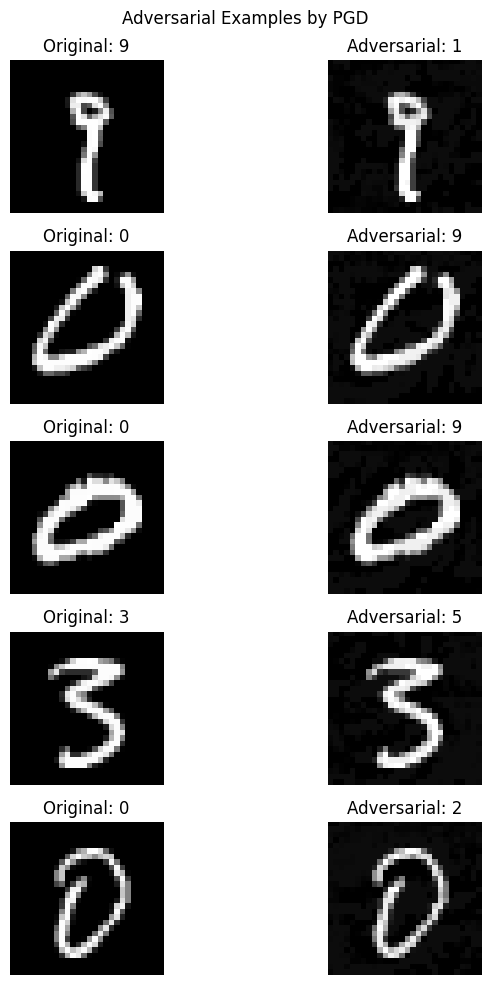

PGD Attack: Epsilon = 0.1, Alpha = 0.01, Iterations = 10, Success rate = 5


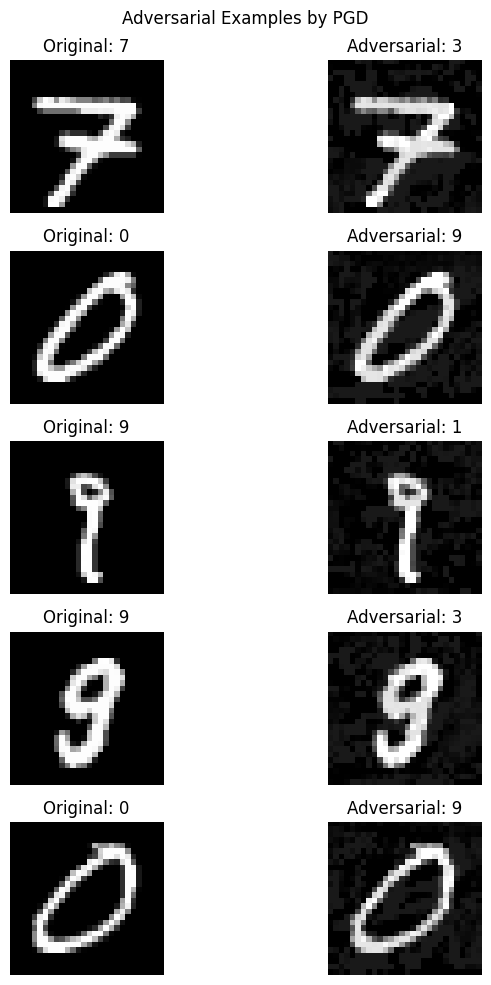

PGD Attack: Epsilon = 0.15, Alpha = 0.01, Iterations = 10, Success rate = 5


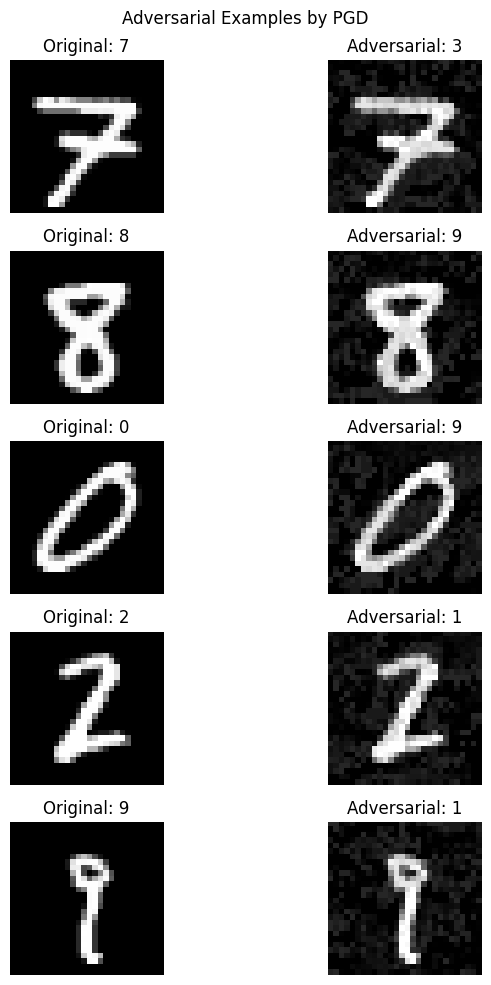

PGD Attack: Epsilon = 0.2, Alpha = 0.01, Iterations = 10, Success rate = 5


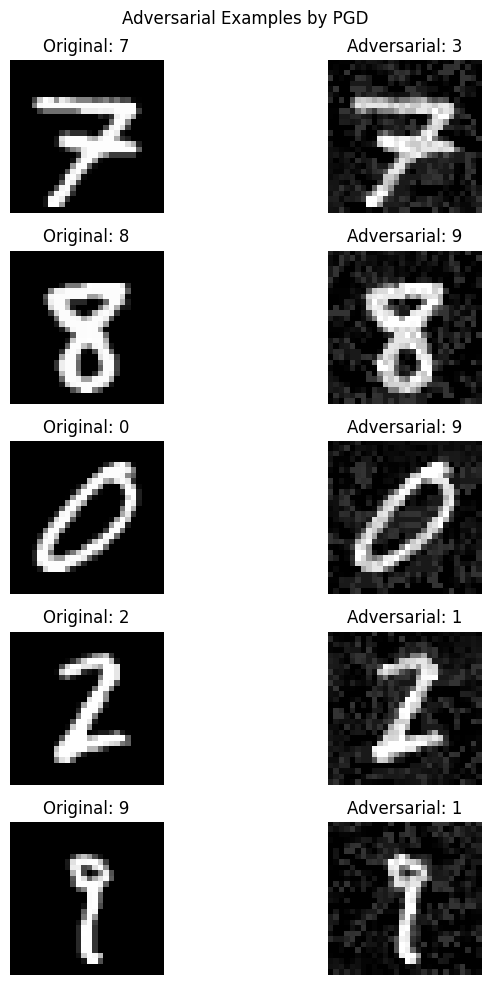

PGD Attack: Epsilon = 0.25, Alpha = 0.01, Iterations = 10, Success rate = 5


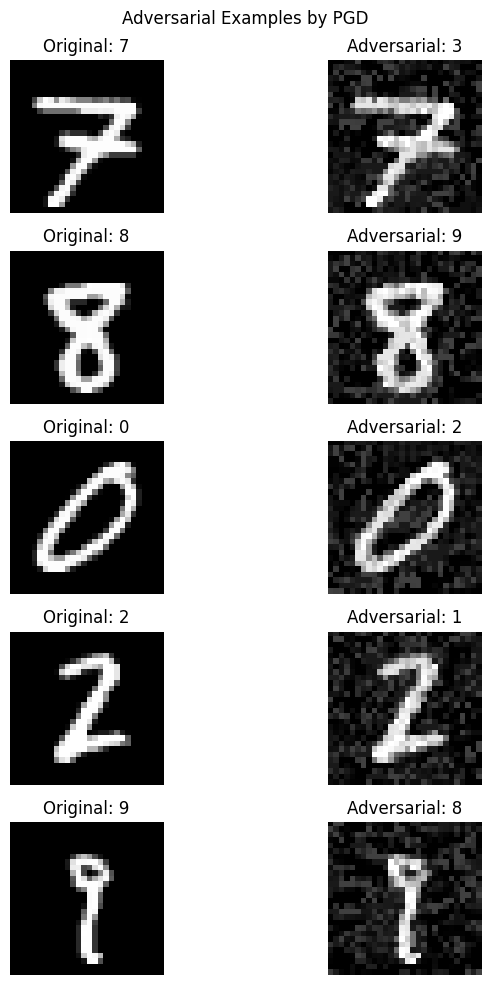

In [9]:
# 3. Compare FGSM, BIM, and PGD
def compare_fgsm_bim_pgd(model, test_loader, epsilon_values, alpha, num_iter):
    # FGSM examples
    print("\n-- FGSM Results --")
    show_adversarial_examples(model, test_loader, epsilon_values)

    # BIM examples
    print("\n-- BIM Results --")
    for epsilon in epsilon_values:
        show_bim_adversarial_examples(model, test_loader, epsilon, alpha, num_iter)

    # PGD examples
    print("\n-- PGD Results --")
    for epsilon in epsilon_values:
        show_pgd_adversarial_examples(model, test_loader, epsilon, alpha, num_iter)


compare_fgsm_bim_pgd(model, test_loader, epsilon_values, alpha, num_iter)

## Adversarial Training and Model Robustness Assessment

### Adversarial Training
Adversarial training is a method used to improve the robustness of a neural network against adversarial attacks. During training, the model is exposed to adversarial examples generated using the Fast Gradient Sign Method (FGSM) alongside clean examples. The idea is to make the model learn how to correctly classify both original and perturbed images, thereby increasing its resistance to adversarial attacks.

### Implementation in This Cell
1. **Model Definition**: A simple CNN model is defined for classifying MNIST digits.
2. **Data Loading**: The MNIST dataset is loaded and preprocessed.
3. **Device Configuration**: The model is set to use a GPU if available.
4. **Adversarial Training**: The model is trained using a combination of clean and FGSM-perturbed images. The `adversarial_train` function is responsible for this process. It generates adversarial examples on-the-fly and combines them with clean images during training.
5. **Robustness Assessment**: After training, the model's robustness is evaluated against FGSM, BIM, and PGD attacks. The success rate of each attack is calculated across different epsilon values, indicating how often the model misclassifies adversarial examples.




In [13]:
# 1. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 7*7*64)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 2. Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 3. Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Instantiate the model, loss, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. FGSM attack function (from previous code)
def fgsm_attack(model, loss_fn, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    output = model(x_adv)
    loss = loss_fn(output, y)
    model.zero_grad()
    loss.backward()
    gradient = x_adv.grad.data
    sign_gradient = gradient.sign()
    x_adv = x_adv + epsilon * sign_gradient
    return x_adv

# 6. Adversarial training function
def adversarial_train(model, train_loader, criterion, optimizer, epsilon, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial examples
            images_adv = fgsm_attack(model, criterion, images, labels, epsilon)

            # Mix clean and adversarial examples
            images_combined = torch.cat([images, images_adv], dim=0)
            labels_combined = torch.cat([labels, labels], dim=0)

            # Forward pass
            outputs = model(images_combined)
            loss = criterion(outputs, labels_combined)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 900 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Train the model adversarially
epsilon = 0.2  # Epsilon for FGSM
adversarial_train(model, train_loader, criterion, optimizer, epsilon, epochs=5)

# 7. Assessment of adversarial robustness
def assess_model(model, test_loader, epsilon_values, alpha, num_iter):
    model.eval()

    def calculate_success_rate(attack_fn, attack_name, epsilon):
        total, success = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Generate adversarial examples
            adv_images = attack_fn(model, criterion, images, labels, epsilon)

            # Re-classify the adversarial images
            outputs = model(adv_images)
            _, preds = outputs.max(1)

            # Count successful attacks
            success += (preds != labels).sum().item()
            total += labels.size(0)

        success_rate = success / total * 100
        print(f"{attack_name} Attack - Epsilon: {epsilon:.3f} Success Rate: {success_rate:.2f}%")

    # FGSM Attack Assessment
    print("\n-- FGSM Attack Assessment --")
    for epsilon in epsilon_values:
        calculate_success_rate(fgsm_attack, "FGSM", epsilon)

    # BIM Attack Assessment
    def bim_attack_wrapper(model, loss_fn, x, y, epsilon):
        return bim_attack(model, loss_fn, x, y, epsilon, alpha, num_iter)

    print("\n-- BIM Attack Assessment --")
    for epsilon in epsilon_values:
        calculate_success_rate(bim_attack_wrapper, "BIM", epsilon)

    # PGD Attack Assessment
    def pgd_attack_wrapper(model, loss_fn, x, y, epsilon):
        return pgd_attack(model, loss_fn, x, y, epsilon, alpha, num_iter)

    print("\n-- PGD Attack Assessment --")
    for epsilon in epsilon_values:
        calculate_success_rate(pgd_attack_wrapper, "PGD", epsilon)

# Parameters for BIM and PGD
alpha = 0.01  # Step size
num_iter = 10  # Number of iterations
epsilon_values = [0.05, 0.1, 0.15]  # Epsilon values for assessment

# Assess adversarial robustness
assess_model(model, test_loader, epsilon_values, alpha, num_iter)


Epoch [1/5], Step [900/938], Loss: 0.1239
Epoch [2/5], Step [900/938], Loss: 0.1138
Epoch [3/5], Step [900/938], Loss: 0.0067
Epoch [4/5], Step [900/938], Loss: 0.0030
Epoch [5/5], Step [900/938], Loss: 0.0409

-- FGSM Attack Assessment --
FGSM Attack - Epsilon: 0.050 Success Rate: 1.00%
FGSM Attack - Epsilon: 0.100 Success Rate: 0.56%
FGSM Attack - Epsilon: 0.150 Success Rate: 0.44%

-- BIM Attack Assessment --
BIM Attack - Epsilon: 0.050 Success Rate: 4.32%
BIM Attack - Epsilon: 0.100 Success Rate: 16.79%
BIM Attack - Epsilon: 0.150 Success Rate: 16.79%

-- PGD Attack Assessment --
PGD Attack - Epsilon: 0.050 Success Rate: 4.21%
PGD Attack - Epsilon: 0.100 Success Rate: 14.81%
PGD Attack - Epsilon: 0.150 Success Rate: 26.94%


### Results Analysis
- **FGSM Attack Assessment**: After adversarial training, the model shows high robustness against FGSM attacks, with very low success rates even at higher epsilon values:
  - Epsilon: 0.050 → Success Rate: 1.00%
  - Epsilon: 0.100 → Success Rate: 0.56%
  - Epsilon: 0.150 → Success Rate: 0.44%

- **BIM Attack Assessment**: The model shows moderate robustness against BIM attacks. As epsilon increases, the success rate of BIM attacks also increases:
  - Epsilon: 0.050 → Success Rate: 4.32%
  - Epsilon: 0.100 → Success Rate: 16.79%
  - Epsilon: 0.150 → Success Rate: 16.79%

- **PGD Attack Assessment**: PGD is more effective than BIM and FGSM, especially at higher epsilon values. The success rate increases more significantly with epsilon:
  - Epsilon: 0.050 → Success Rate: 4.21%
  - Epsilon: 0.100 → Success Rate: 14.81%
  - Epsilon: 0.150 → Success Rate: 26.94%

### Conclusion
The adversarial training has made the model robust against simple FGSM attacks, as evidenced by the low success rates. However, more sophisticated attacks like BIM and PGD, especially with higher epsilon values, still pose a significant challenge, suggesting that while adversarial training is effective, it may need to be combined with other techniques to fully defend against more advanced attacks.